In [23]:
import os
from typing import List
import random
import glob
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cpu


In [25]:
df: pd.DataFrame = pd.read_csv('paths2.csv', usecols=["Absolute path", "Class name"])
df: pd.DataFrame = df.rename(columns={'Absolute path': 'absPath',
               'Class name': 'className'})

In [26]:
probs = np.random.rand(len(df))
training_mask = probs < 0.8
test_mask = (probs>=0.8) & (probs < 0.9)
validatoin_mask = probs >= 0.9

df_training = df[training_mask]
df_test = df[test_mask]
df_validation = df[validatoin_mask]

print(df_training)
print(df_test)
print(df_validation)

                                                absPath className
1     C:\Users\nikku\Desktop\3labpy\dataset2\rose_00...      rose
2     C:\Users\nikku\Desktop\3labpy\dataset2\rose_00...      rose
3     C:\Users\nikku\Desktop\3labpy\dataset2\rose_00...      rose
5     C:\Users\nikku\Desktop\3labpy\dataset2\rose_00...      rose
6     C:\Users\nikku\Desktop\3labpy\dataset2\rose_00...      rose
...                                                 ...       ...
1994  C:\Users\nikku\Desktop\3labpy\dataset2\tulip_0...     tulip
1995  C:\Users\nikku\Desktop\3labpy\dataset2\tulip_0...     tulip
1996  C:\Users\nikku\Desktop\3labpy\dataset2\tulip_0...     tulip
1997  C:\Users\nikku\Desktop\3labpy\dataset2\tulip_0...     tulip
1998  C:\Users\nikku\Desktop\3labpy\dataset2\tulip_0...     tulip

[1598 rows x 2 columns]
                                                absPath className
0     C:\Users\nikku\Desktop\3labpy\dataset2\rose_00...      rose
8     C:\Users\nikku\Desktop\3labpy\dataset2\rose_0

In [27]:
train_path='C:/Users/nikku/Desktop/5labpy/train2'
test_path='C:/Users/nikku/Desktop/5labpy/test2'
val_path='C:/Users/nikku/Desktop/5labpy/val2'

if not os.path.isdir(train_path):
    os.mkdir(train_path)

if not os.path.isdir(test_path):
    os.mkdir(test_path)
    
if not os.path.isdir(val_path):
    os.mkdir(val_path)

In [28]:
i = 0
for path in df_training["absPath"]:
    class_name = path.split('\\')[-1].split('.')[0].split('_')[0]
    image = cv2.imread(path)
    cv2.imwrite(os.path.join(train_path, f'{class_name}.{i}.jpg'), image)
    i+=1

for path in df_test["absPath"]:
    image = cv2.imread(path)
    cv2.imwrite(os.path.join(test_path, f'{i}.jpg'), image)
    i+=1

for path in df_validation["absPath"]:
    class_name = path.split('\\')[-1].split('.')[0].split('_')[0]
    image = cv2.imread(path)
    cv2.imwrite(os.path.join(val_path, f'{class_name}.{i}.jpg'), image)
    i+=1

In [29]:
train_list: List[str] = glob.glob(os.path.join(train_path,'*.jpg'))
test_list: List[str] = glob.glob(os.path.join(test_path, '*.jpg'))
val_list: List[str] = glob.glob(os.path.join(val_path,'*.jpg'))

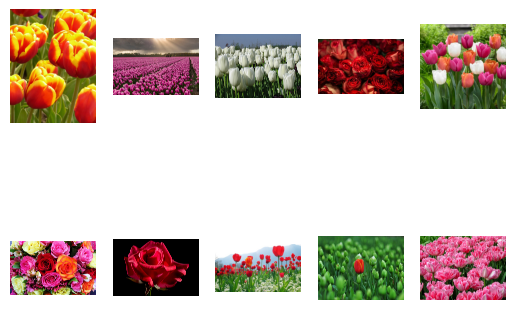

In [30]:
random_idx = np.random.randint(1,len(train_list),size=10)
fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(train_list[idx])
    plt.imshow(img)
    i+=1
    plt.axis('off')
plt.show()

In [31]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
   
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('\\')[-1].split('.')[0]
        if label == 'tulip':
            label=1
        elif label == 'rose':
            label=0
            
        return img_transformed,label

In [32]:
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])
val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])
test_transforms = transforms.Compose([   
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

In [33]:
train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=val_transforms)

In [34]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [35]:
model = CNN().to(device)
model.train()

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [36]:
parameters = {'lr':[0.001,0.01],
              'batch_size':[16,32]}

Learning rate: 0.001, Batch size: 16
Epoch : 1, train accuracy : 0.7423138618469238, train loss : 0.5167884826660156
Epoch : 1, val_accuracy : 0.7809524536132812, val_loss : 0.4716545641422272
Epoch : 2, train accuracy : 0.7692154049873352, train loss : 0.4741038978099823
Epoch : 2, val_accuracy : 0.797619104385376, val_loss : 0.4343792498111725
Epoch : 3, train accuracy : 0.7686083316802979, train loss : 0.4669208228588104
Epoch : 3, val_accuracy : 0.7809524536132812, val_loss : 0.42615899443626404
Epoch : 4, train accuracy : 0.7910599708557129, train loss : 0.43884938955307007
Epoch : 4, val_accuracy : 0.8529762625694275, val_loss : 0.3537871241569519
Epoch : 5, train accuracy : 0.8050163984298706, train loss : 0.4206554591655731
Epoch : 5, val_accuracy : 0.8375000357627869, val_loss : 0.41127386689186096
Epoch : 6, train accuracy : 0.8102751970291138, train loss : 0.41640958189964294
Epoch : 6, val_accuracy : 0.8666666746139526, val_loss : 0.32187095284461975
Epoch : 7, train accura

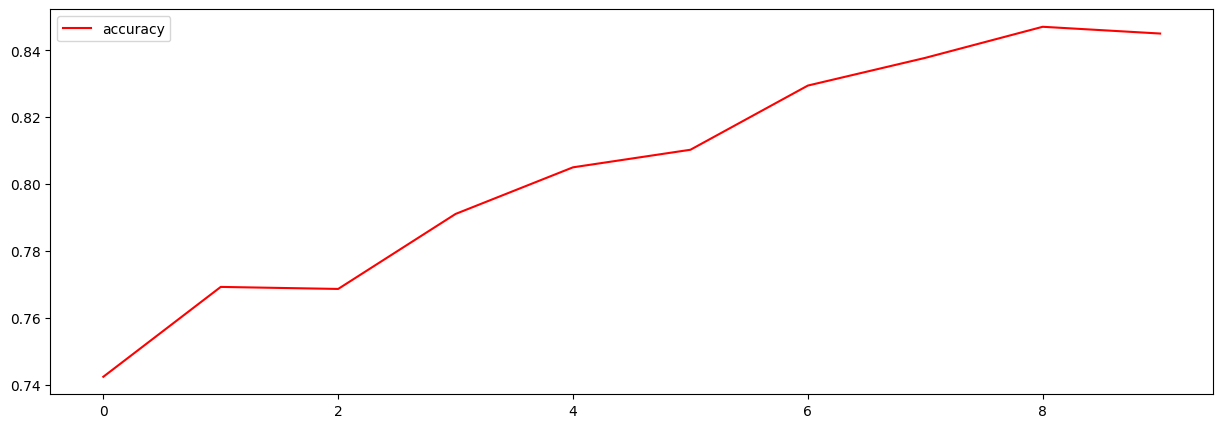

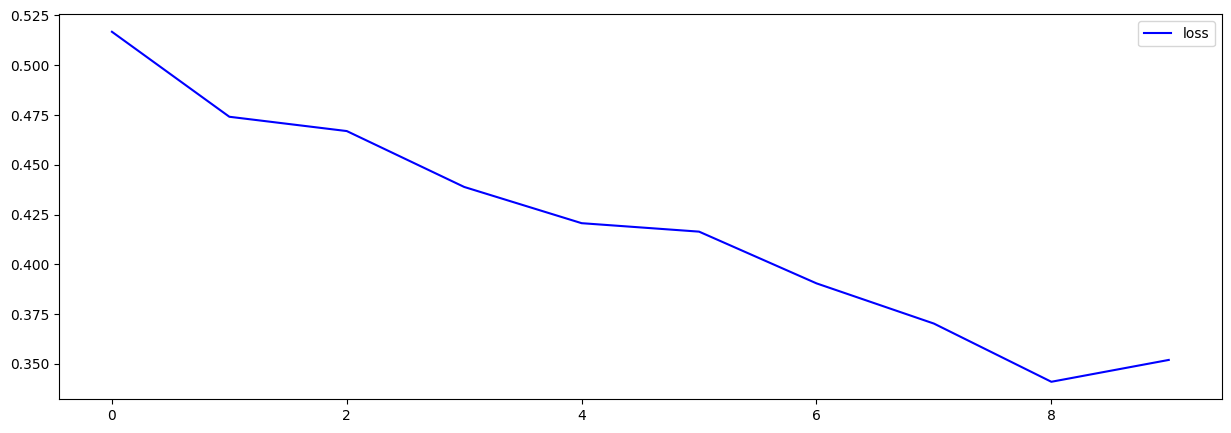

The graph for the validation sample


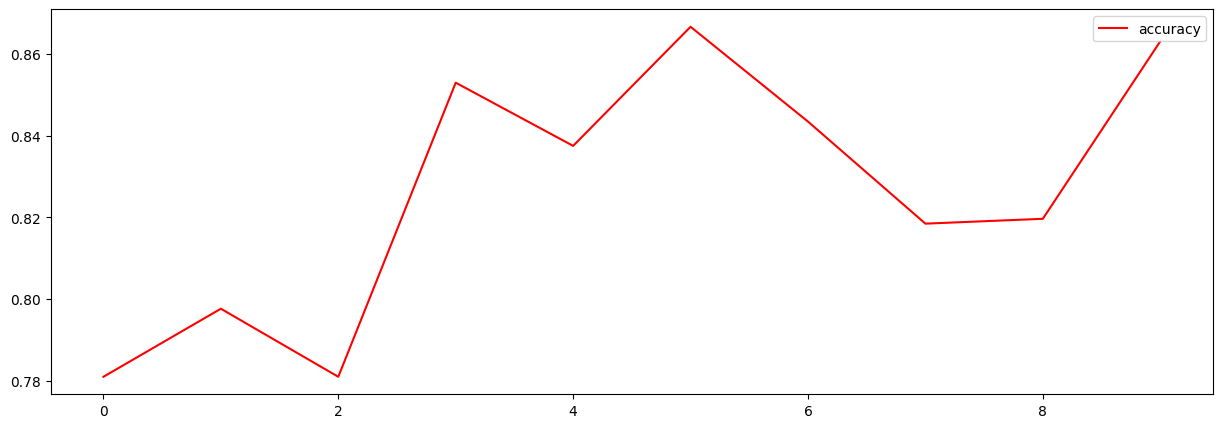

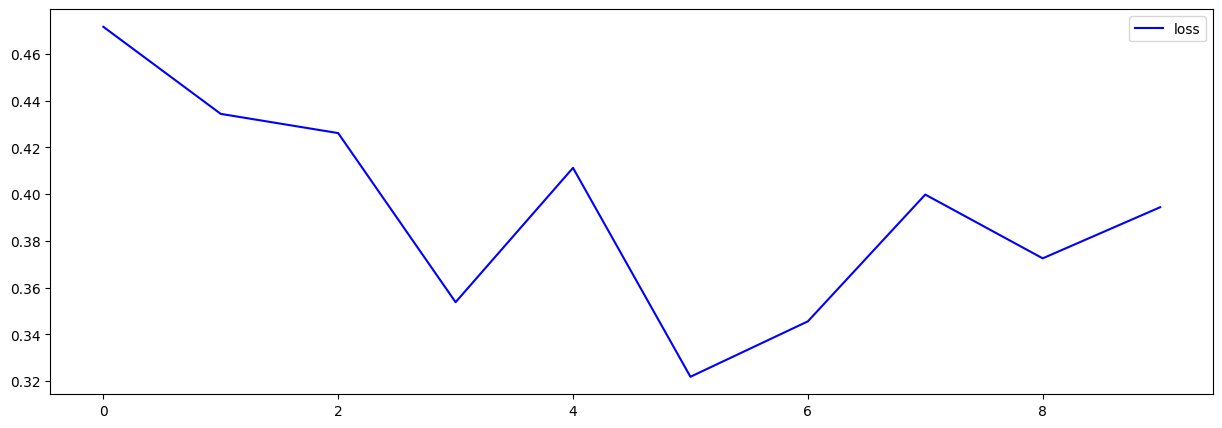

Learning rate: 0.001, Batch size: 32
Epoch : 1, train accuracy : 0.8587740063667297, train loss : 0.30127397179603577
Epoch : 1, val_accuracy : 0.87109375, val_loss : 0.30111557245254517
Epoch : 2, train accuracy : 0.8611777424812317, train loss : 0.31152665615081787
Epoch : 2, val_accuracy : 0.8610491156578064, val_loss : 0.29542598128318787
Epoch : 3, train accuracy : 0.8637819886207581, train loss : 0.2993190288543701
Epoch : 3, val_accuracy : 0.91796875, val_loss : 0.25545555353164673
Epoch : 4, train accuracy : 0.8786057233810425, train loss : 0.28821760416030884
Epoch : 4, val_accuracy : 0.8822544813156128, val_loss : 0.2997363209724426
Epoch : 5, train accuracy : 0.8637819290161133, train loss : 0.29840850830078125
Epoch : 5, val_accuracy : 0.8387276530265808, val_loss : 0.37430015206336975
Epoch : 6, train accuracy : 0.8794070482254028, train loss : 0.2830040156841278
Epoch : 6, val_accuracy : 0.8844866156578064, val_loss : 0.31815212965011597
Epoch : 7, train accuracy : 0.8725

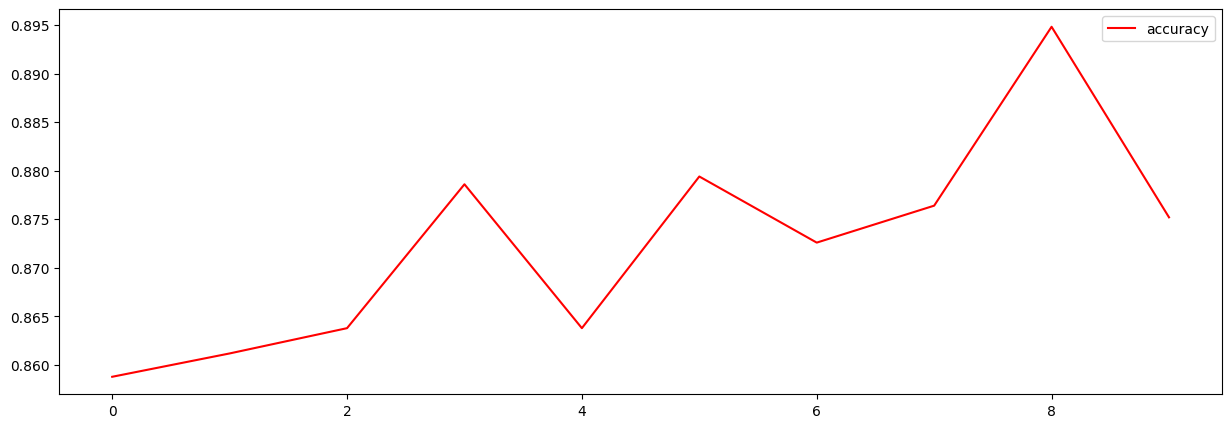

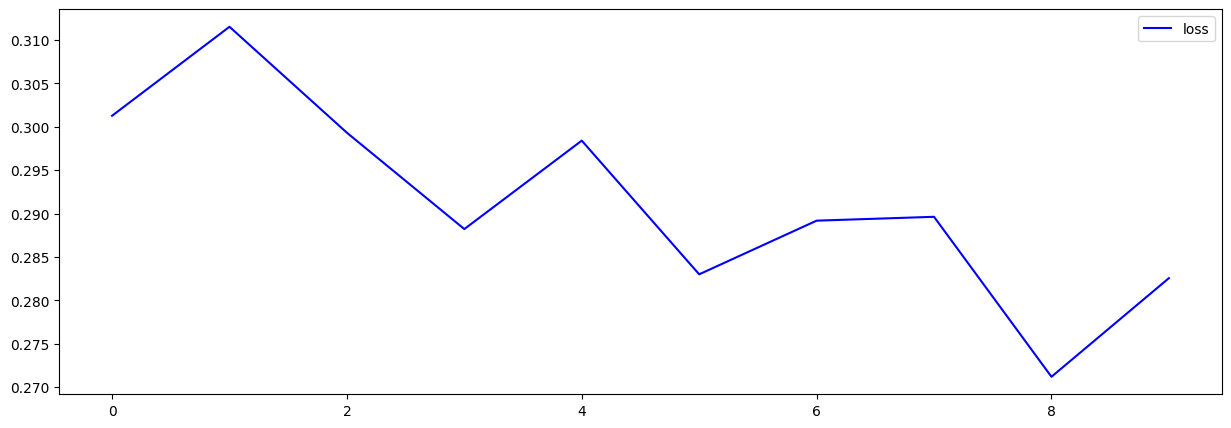

The graph for the validation sample


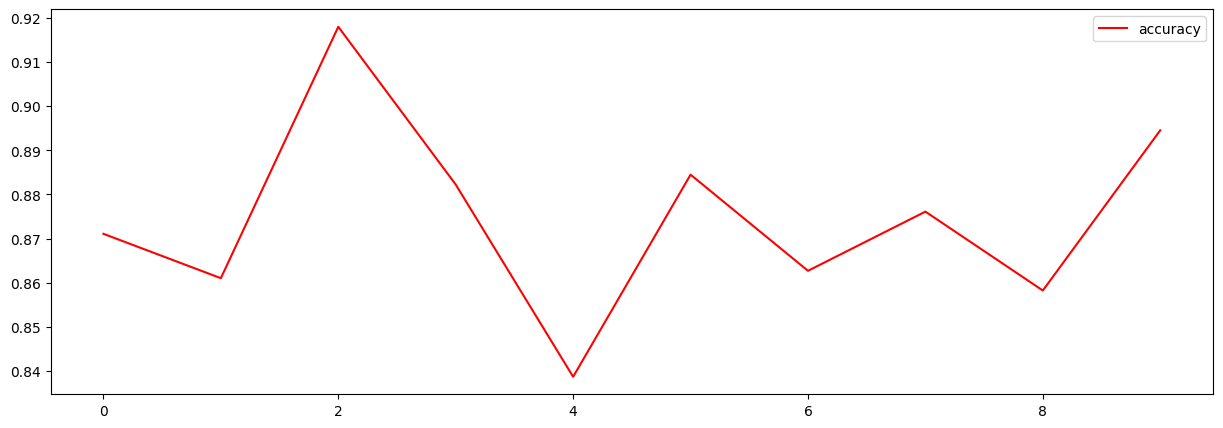

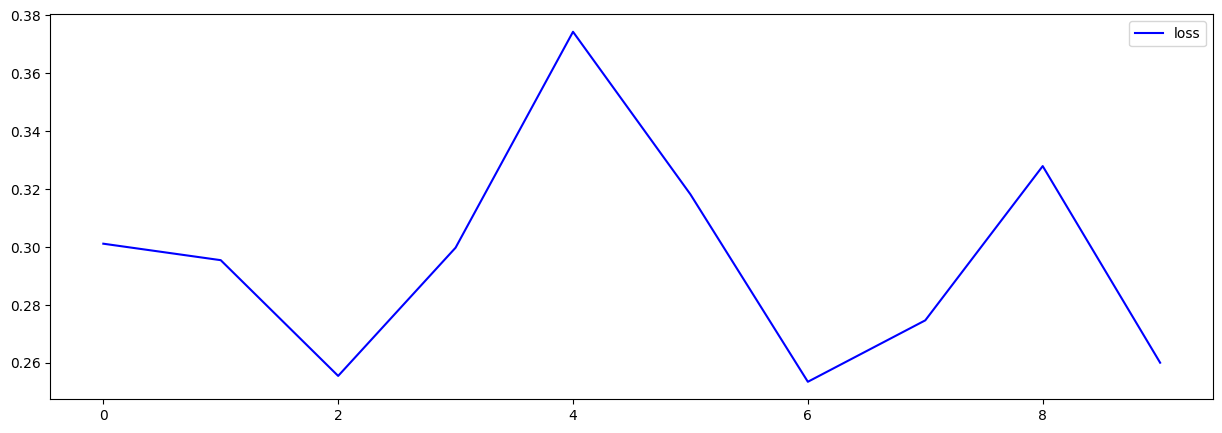

Learning rate: 0.01, Batch size: 16
Epoch : 1, train accuracy : 0.7293691039085388, train loss : 0.5945220589637756
Epoch : 1, val_accuracy : 0.7321429252624512, val_loss : 0.5478318929672241
Epoch : 2, train accuracy : 0.74817955493927, train loss : 0.5285032987594604
Epoch : 2, val_accuracy : 0.8017857670783997, val_loss : 0.5033036470413208
Epoch : 3, train accuracy : 0.763349711894989, train loss : 0.4925262928009033
Epoch : 3, val_accuracy : 0.7672619819641113, val_loss : 0.5119034051895142
Epoch : 4, train accuracy : 0.7809467911720276, train loss : 0.47859662771224976
Epoch : 4, val_accuracy : 0.8005952835083008, val_loss : 0.4440482258796692
Epoch : 5, train accuracy : 0.7940938472747803, train loss : 0.46013715863227844
Epoch : 5, val_accuracy : 0.8666667342185974, val_loss : 0.37018707394599915
Epoch : 6, train accuracy : 0.8092639446258545, train loss : 0.4406825006008148
Epoch : 6, val_accuracy : 0.8059523701667786, val_loss : 0.48682814836502075
Epoch : 7, train accuracy :

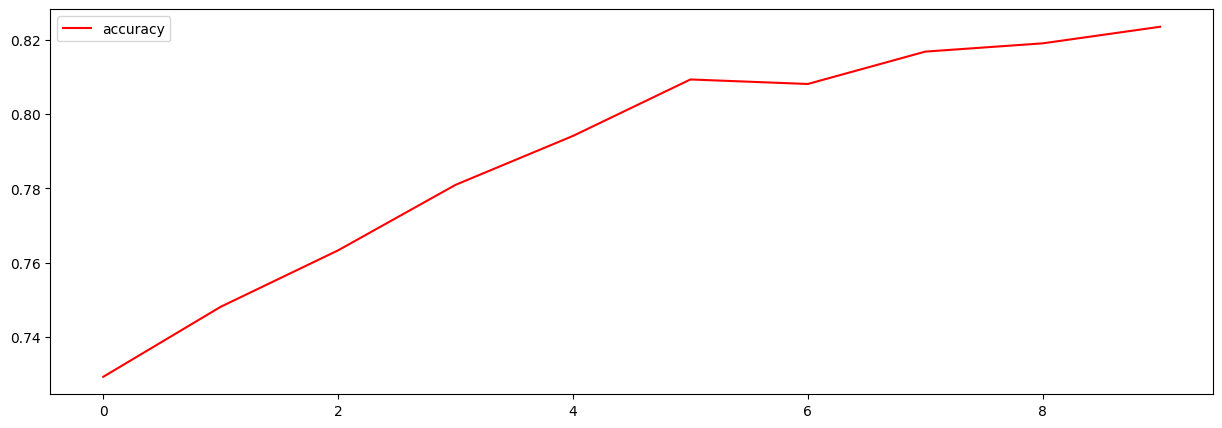

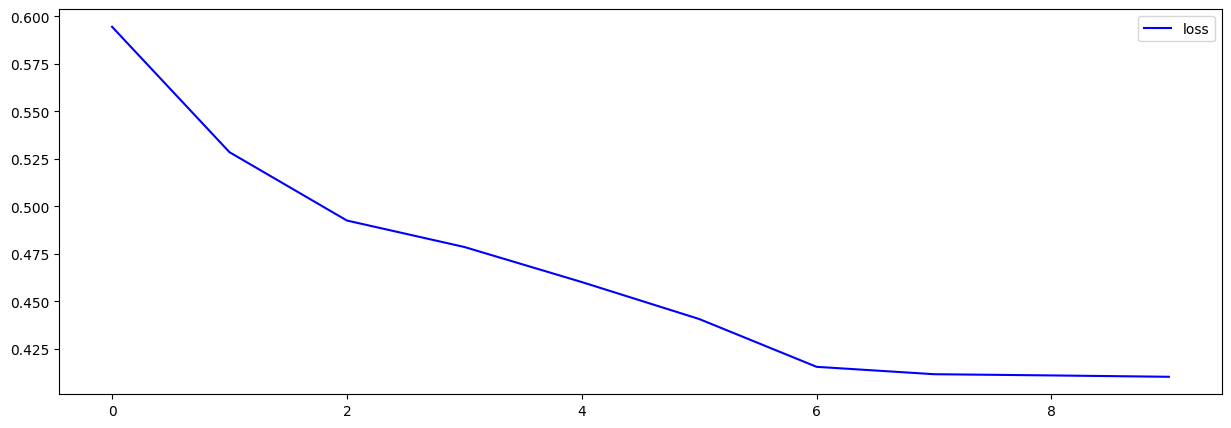

The graph for the validation sample


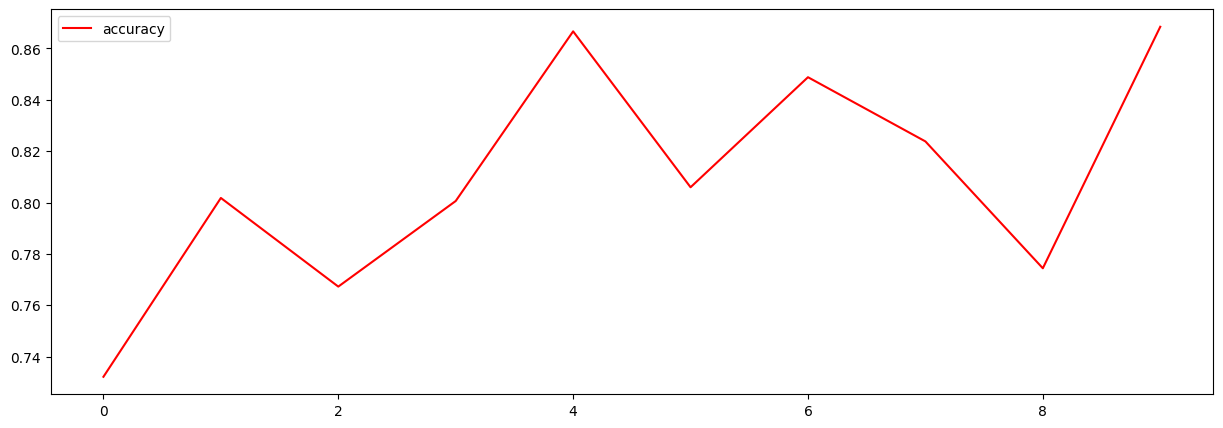

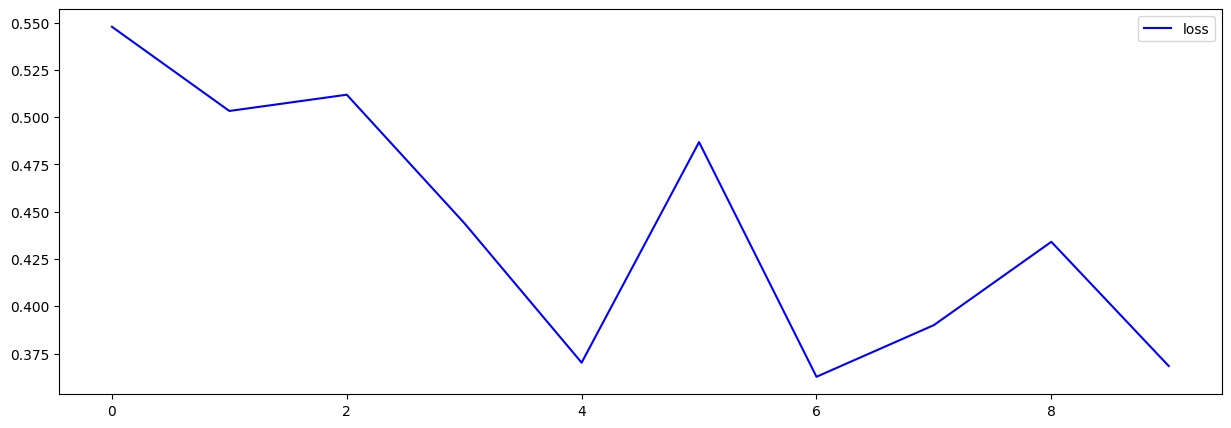

Learning rate: 0.01, Batch size: 32
Epoch : 1, train accuracy : 0.8565704822540283, train loss : 0.33378833532333374
Epoch : 1, val_accuracy : 0.87890625, val_loss : 0.27157413959503174
Epoch : 2, train accuracy : 0.8519629836082458, train loss : 0.342138409614563
Epoch : 2, val_accuracy : 0.88671875, val_loss : 0.28260597586631775
Epoch : 3, train accuracy : 0.8545671701431274, train loss : 0.33541083335876465
Epoch : 3, val_accuracy : 0.8766741156578064, val_loss : 0.3013104796409607
Epoch : 4, train accuracy : 0.862379789352417, train loss : 0.3195374310016632
Epoch : 4, val_accuracy : 0.86328125, val_loss : 0.29226723313331604
Epoch : 5, train accuracy : 0.8689901828765869, train loss : 0.30877843499183655
Epoch : 5, val_accuracy : 0.8705357313156128, val_loss : 0.29281094670295715
Epoch : 6, train accuracy : 0.8483572602272034, train loss : 0.3510001599788666
Epoch : 6, val_accuracy : 0.8766741156578064, val_loss : 0.29438287019729614
Epoch : 7, train accuracy : 0.8539663553237915

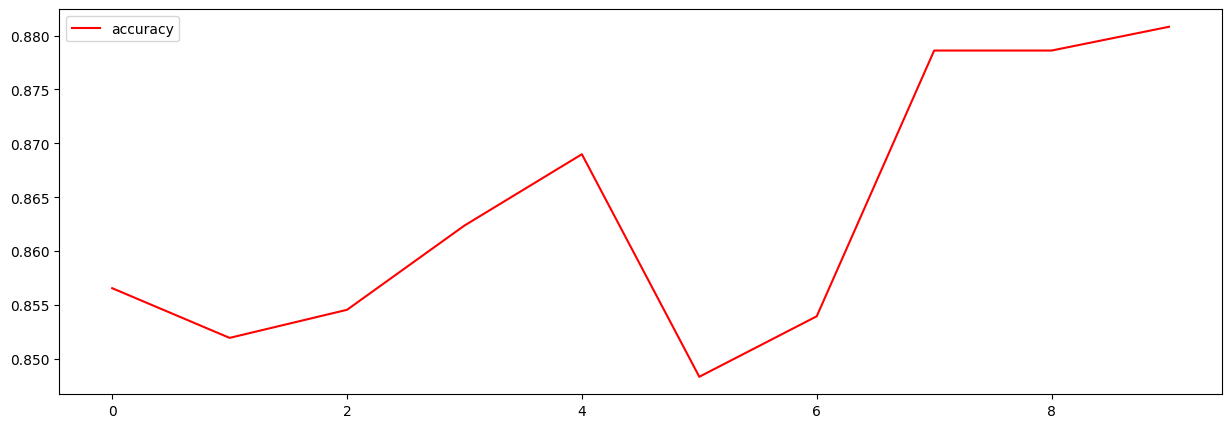

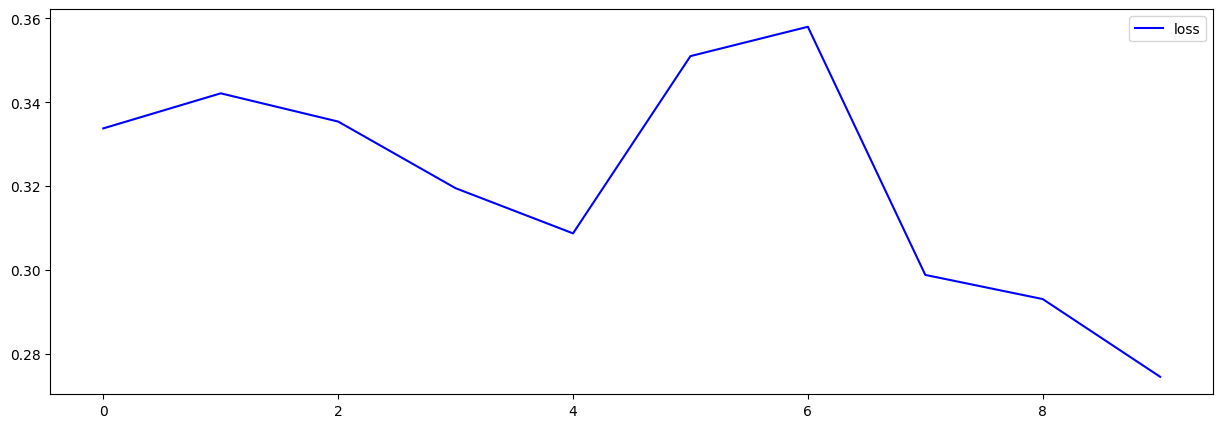

The graph for the validation sample


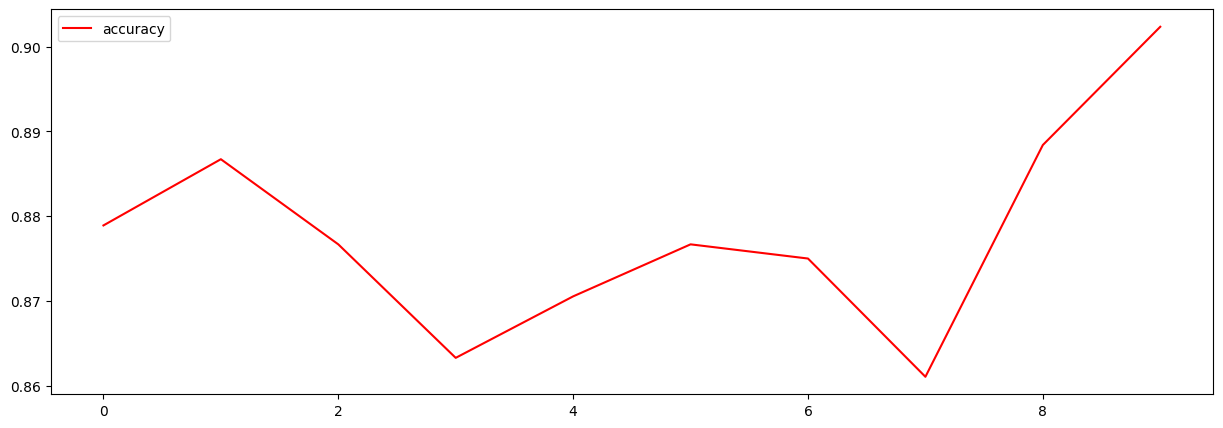

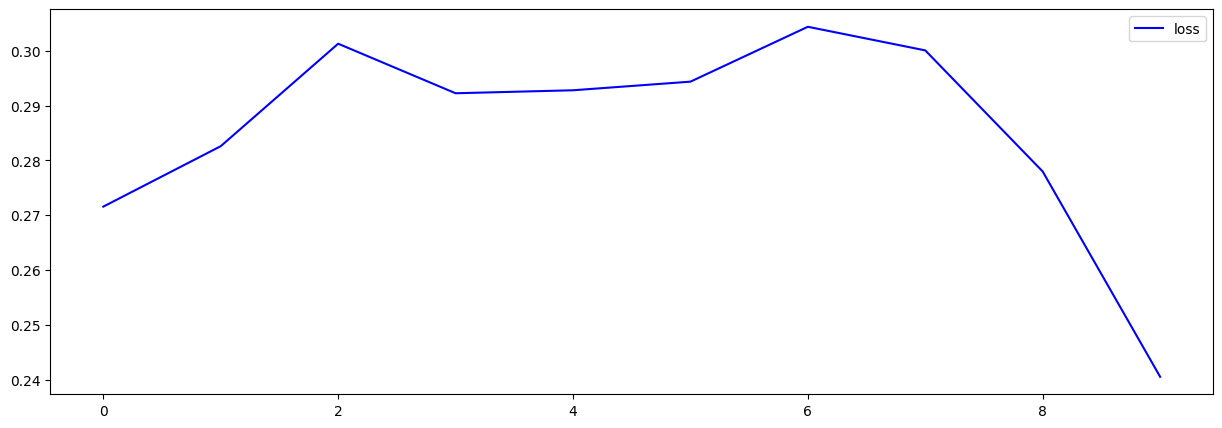

In [37]:
for lr in parameters['lr']:
    for bs in parameters['batch_size']:
        print('Learning rate: {}, Batch size: {}'.format(lr,bs))

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=bs, shuffle=True )
        test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=bs, shuffle=True)
        val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=bs, shuffle=True)

        epochs = 10
        def train_loop (train_loader, val_loader, epochs):
            val_loss_list = []
            val_accuracy_list = []

            loss_list = []
            accuracy_list = []

            for epoch in range(epochs):
                epoch_loss = 0
                epoch_accuracy = 0
                for data, label in train_loader:
                    data = data.to(device)
                    label = label.to(device)

                    output = model(data)
                    loss = criterion(output, label)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    acc = ((output.argmax(dim=1) == label).float().mean())
                    epoch_accuracy += acc/len(train_loader)
                    epoch_loss += loss/len(train_loader)

                loss_list.append(epoch_loss.item())
                accuracy_list.append(epoch_accuracy.item())

                print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))


                with torch.no_grad():
                    epoch_val_accuracy=0
                    epoch_val_loss =0
                    
                    for data, label in val_loader:
                        data = data.to(device)
                        label = label.to(device)

                        val_output = model(data)
                        val_loss = criterion(val_output,label)

                        acc = ((val_output.argmax(dim=1) == label).float().mean())
                        epoch_val_accuracy += acc/ len(val_loader)
                        epoch_val_loss += val_loss/ len(val_loader)


                    val_loss_list.append(epoch_val_loss.item())
                    val_accuracy_list.append(epoch_val_accuracy.item())

                    print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))


            print("\nThe graph for the training sample")

            plt.figure(figsize=(15, 5))
            plt.plot(range(10), accuracy_list, color="red")
            plt.legend(["accuracy"])
            plt.show()

            plt.figure(figsize=(15, 5))
            plt.plot(range(10), loss_list, color="blue")
            plt.legend(["loss"])
            plt.show() 

            print("The graph for the validation sample")

            plt.figure(figsize=(15, 5))
            plt.plot(range(10), val_accuracy_list, color="red")
            plt.legend(["accuracy"])
            plt.show()

            plt.figure(figsize=(15, 5))
            plt.plot(range(10), val_loss_list, color="blue")
            plt.legend(["loss"])
            plt.show() 

        train_loop(train_loader, val_loader, epochs)

In [38]:
rose_probs = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        preds = model(images)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        rose_probs += list(zip(labels, preds_list))

rose_probs.sort(key = lambda x : int(x[0]))     
idx = list(map(lambda x: x[0],rose_probs))
prob = list(map(lambda x: x[1],rose_probs))

submission = pd.DataFrame({'id':idx,'label':prob})

submission

,id,label
0,1586,0.056077
1,1587,0.056077
2,1588,0.056077
3,1589,0.056077
4,1590,0.056824
...,...,...
226,1812,0.978664
227,1813,0.998516
228,1814,0.689932
229,1815,0.768544


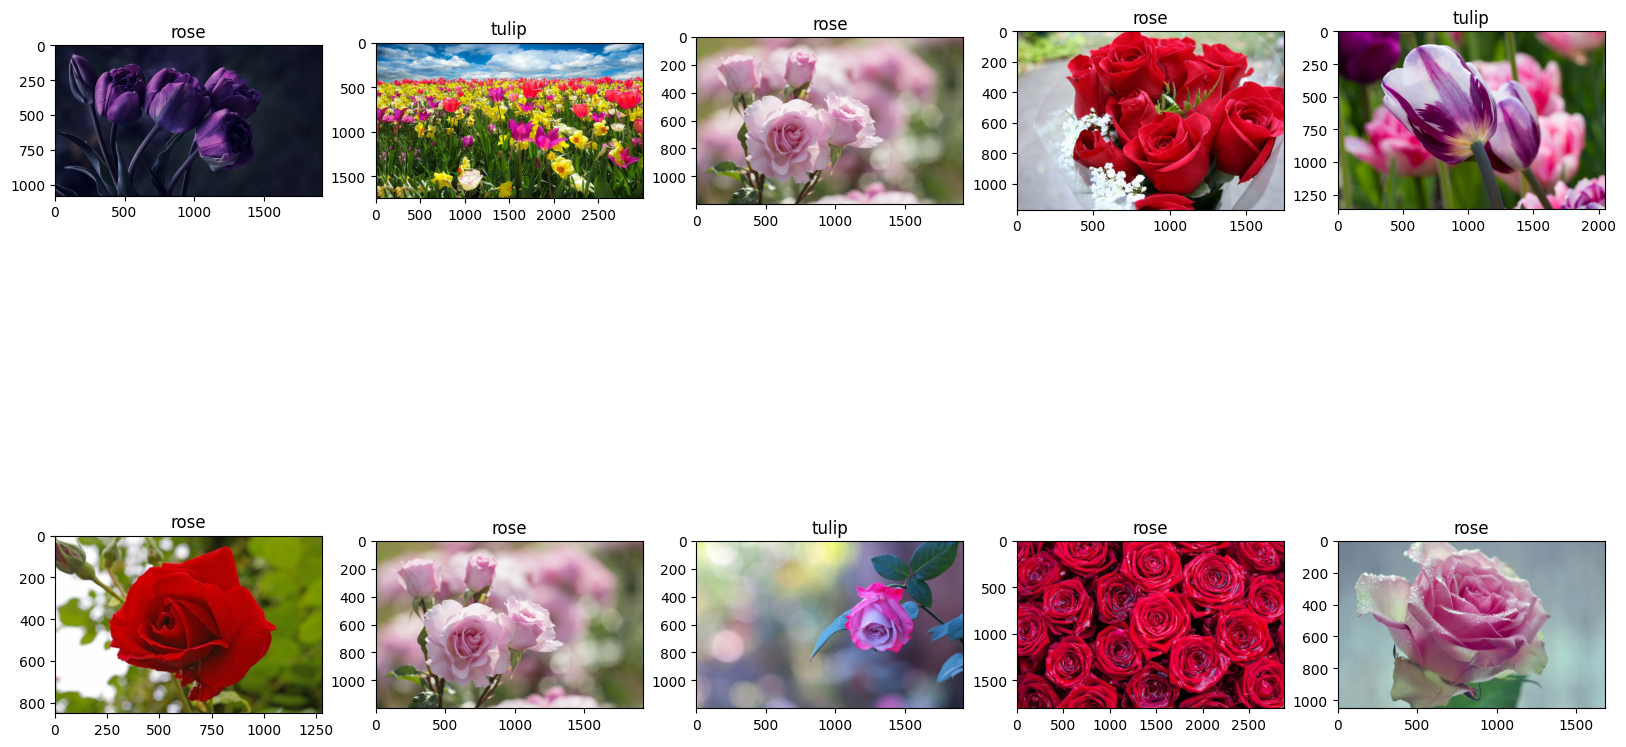

In [39]:
class_ = {0: 'rose', 1: 'tulip'}

fig, axes = plt.subplots(2, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = os.path.join(test_path, '{}.jpg'.format(i))
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)

In [40]:
torch.save(model.state_dict(), 'CNNmodel.pt')

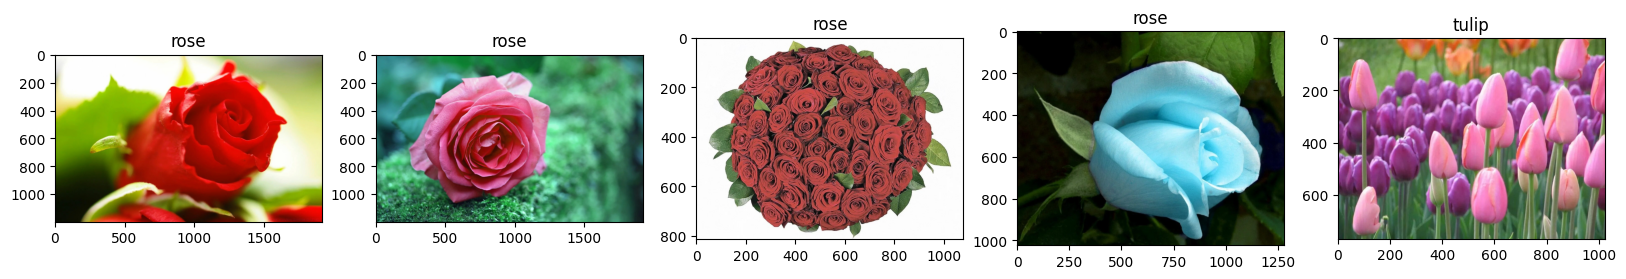

In [41]:
loaded_model = CNN()
loaded_model.load_state_dict(torch.load('CNNmodel.pt'))
loaded_model.to(device)

tulip_probs = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        preds = loaded_model(images)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        tulip_probs += list(zip(labels, preds_list))
        
idx = list(map(lambda x: x[0],tulip_probs))
prob = list(map(lambda x: x[1],tulip_probs))

submission = pd.DataFrame({'id':idx,'label':prob})

class_ = {0: 'rose', 1: 'tulip'}

fig, axes = plt.subplots(1, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = os.path.join(test_path, f'{i}.jpg')
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)